In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import pickle
from matplotlib import pyplot as plt

from module_.info.testbed import activityfiles_new
from module_.info.config import config, feature_name
from module_.readText import create_episodes, time_correction
from module_.featureExtraction import feature_extraction
from module_.changePointDetection import change_point_detection
from module_.dataLoader import dataLoader

In [2]:
episodes, transitions, labels = dataLoader("testbed")

sensors = set()
for episode in episodes:
    sensors = sensors | set(episode[:,0])
sensors = sorted(sensors)

tasks: ['Chatting', 'Discussion', 'GroupStudy', 'Presentation']


In [ ]:
# CALCULATION

sensors = set()
for episode in episodes:
    sensors = sensors | set(episode[:,0])
sensors = sorted(sensors)

scores = []
features = []

for index in range(len(episodes)):
    episode, transition, label = episodes[index], transitions[index], labels[index]

    feature = np.array(
        feature_extraction(episode, "testbed", sensors)
    )

    score = np.array(
        change_point_detection(feature, "RuLSIF")
    )

    scores.append(score)
    features.append(feature)

np.save("./replication/testbed/scores_lftcnt.npy", scores)
np.save("./replication/testbed/features_lftcnt.npy", features)

In [25]:
# EVALUATION

sensors = set()
for episode in episodes:
    sensors = sensors | set(episode[:,0])
sensors = sorted(sensors)

# scores = np.load("./replication/RuLSIF/testbed/scores_original.npy", allow_pickle=True)
# features = np.load("./replication/RuLSIF/testbed/features_original.npy", allow_pickle=True)

threshold = 0.5

tp = tn = fp = fn = 0

set_ = set()

for index in range(len(episodes)):

    if index<11:
        continue

    episode, transition, label = episodes[index], transitions[index], labels[index]

    feature = np.array(
        feature_extraction(episode, "testbed", sensors)
    )

    score = np.array(
        change_point_detection(feature, "RuLSIF")
    )

    tl, tr = float(episode[transition-1,2]), float(episode[transition,2])

    etp = etn = efp = efn = 0

    for i in range(len(episode)):
        s, v, t = episode[i][:3]
        t = float(t)

        if score[i]>threshold:
            if abs(t-tl)<60 or abs(t-tr)<60:
                etp+=1
            else:
                efp+=1

                set_.add(int(t/60))
        else:
            if i==transition or i==transition-1:
                efn+=1
            else:
                etn+=1
    if etp!=0:
        efn = 0
        etp = 1

    tp+=etp; tn+=etn; fp+=efp; fn+=efn

    break

# print(tp/(tp+fn), fp/(fp+tn))
# print(tp/len(episodes), 0.5*fn/len(episodes), fp/len(episodes))
print(tp, tn, fp, fn)
print(len(set_))

1 375 11 0
10


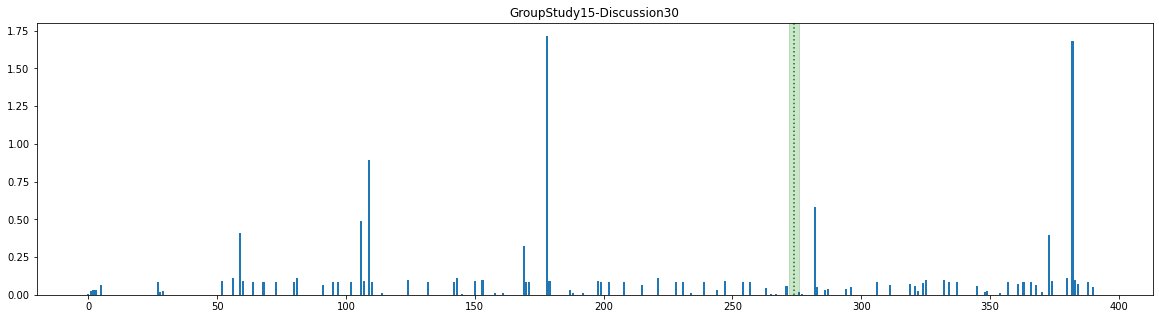

In [21]:
# PLOT SAMPLE

sensors = set()
for episode in episodes:
    sensors = sensors | set(episode[:,0])
sensors = sorted(sensors)

index = 7


episode, transition, label = episodes[index], transitions[index], labels[index]

feature = np.array(
    feature_extraction(episode, "testbed", sensors)
)

score = np.array(
    change_point_detection(feature, "RuLSIF")
)

score[score<0]=0

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(1, 1, 1)

plt.title(label)
plt.bar(range(len(score)), score)
for trans in [transition]:
    lb, ub = trans-1, trans
    tl, tr = float(episode[lb,2]), float(episode[ub,2])
    while tl-float(episode[lb,2])<5. and lb!=0:
        lb-=1
    while float(episode[ub,2])-tr<5. and lb!=len(episode)-1:
        ub+=1
    plt.axvline(
        trans, linestyle="dotted", color="g"
    )
    plt.axvspan(
        lb, ub, alpha=0.2, color='g'
    )

In [ ]:
# PREPROCESSING

idx = 1

episode, transition, label = episodes[idx], transitions[idx], labels[idx]

start_time = int(episode[0,2])
end_time = int(episode[-1, 2])
vectors = []

transition_time_l = int(episode[transition-1][2])
transition_time_r = int(episode[transition][2])

sensor_state = {sensor:False for sensor in sensors}
updated_time = {sensor:start_time for sensor in sensors}

current_time = start_time
eindex = 0
l = []
while current_time!=end_time:

    state_vector = np.zeros(len(sensors))

    while int(episode[eindex, 2])<=current_time:
        s, v, t = episode[eindex][:3]
        t = int(t)

        if s[0]=="M":
            if v=="true":
                sensor_state[s]=True
                updated_time[s]=t
            else:
                sensor_state[s]=False

        eindex+=1

    for sensor in sensors:
        si = sensors.index(sensor)
        
        state_vector[si]=1 if sensor_state[sensor] else 0

    # l.append((int(current_time), state_vector))
    l.append(state_vector)

    current_time+=1

    for sensor in sensors:
        if sensor_state[sensor] and t-updated_time[sensor]>40.: # Time exceed
            sensor_state[sensor]=False

    


# for ei in range(len(episode)):
#     s, v, t = episode[ei]
#     t = float(t)-start_time
#     state_vector = np.zeros(len(sensors))

#     if s[0]=="M":
#         if v=="true":
#             sensor_state[s]=True
#             updated_time[s]=t
#         else:
#             sensor_state[s]=False
#         if sensor_state[s] and t-updated_time[s]>60.: # Time exceed
#             sensor_state[s]=False
    
#     for sensor in sensors:
#         si = sensors.index(sensor)
        
#         state_vector[si]=1 if sensor_state[sensor] else 0

#     vectors.append(state_vector)


In [ ]:
from itertools import combinations

matrix = np.zeros((len(sensors), len(sensors)))

interval = 30

scores = []

for i in range(0, len(l), interval):

    # matrix *= 0.9

    state = np.mean(l[i:i+interval], axis=0)

    on_sensors = [j for j in range(len(state)) if state[j]>0.]

    if i==0:
        scores.append(0.)
    else:

        score = 0.
        for a, b in list(combinations(on_sensors, 2)):
            score += matrix[a, b]
        # done = []
        # for j in on_sensors:
        #     for k in range(len(matrix[j])):
        #         if k in on_sensors and k!=j and (min(j, k), max(j, k)) not in done:
        #             score+=matrix[j][k]
        #             done.append((min(j, k), max(j, k)))

        scores.append(score)
        

    for a, b in list(combinations(on_sensors, 2)):
        # matrix[a, b] = matrix[a, b]*0.9 + 0.1*state[a]*state[b]
        # matrix[b, a] = matrix[b, a]*0.9 + 0.1*state[a]*state[b]

        matrix[a, b] += state[a]*state[b]
        matrix[b, a] += state[a]*state[b]


In [ ]:
plt.plot(range(0, len(l), interval), scores)
plt.axvspan(transition_time_l-start_time-60, transition_time_r-start_time+60, color='g', alpha=0.1)

In [ ]:
# PLOT

fig = plt.figure(figsize=(20, 5))
ax = plt.axes()

l_ = np.array(l)
for i in range(l_.shape[1]):
    sensor_state = l_[:,i]
    plt.plot(range(len(sensor_state)), [i if sensor_state[k]==1. else -1 for k in range(len(sensor_state))], label=sensors[i])
plt.title(label)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper right")
plt.axvspan(transition_time_l-start_time-60, transition_time_r-start_time+60, color='g', alpha=0.1)
plt.yticks(range(-1, len(sensors)))

In [ ]:
values = []
interval = 30
for i in range(0, len(l), interval):
    avg_vector = np.array(l[i:i+interval])
    avg_vector = np.mean(avg_vector, axis=0)
    values.append(avg_vector)

In [ ]:
diffs = []
prev = None
for i in range(len(values)-1):
    diff = np.linalg.norm(values[i+1]-values[i])
    diffs.append(diff)

In [ ]:
# 30초 씩 자른 결과

fig = plt.figure(figsize=(20, 5))
ax = plt.axes()

plt.plot(np.array([t for t in range(int(start_time), int(end_time), interval)][:-1])-start_time, diffs)
plt.axvspan(transition-30, transition+30, alpha=0.2)
plt.xticks([transition-30, transition+30], rotation=45)